In [3]:
# Import all the things

import json
import pandas as pd
import numpy as np
import datetime
import acquire
from prepare import basic_clean, tokenize, lemmatize, stem, remove_stopwords
import wrangle 
import re
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

import nltk

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

### Acquire

merge host_map to utterances

In [96]:
df = pd.read_csv('./utterances.csv')
ep_df = pd.read_csv('./episodes.csv')


In [97]:
df['speaker'] = df.speaker.str.lower()

In [98]:
# joining utterances df ('df') and episodes on 'id'
joined_df = pd.merge(df, ep_df, left_on = 'episode', right_on='id', how = 'inner')
joined_df.drop(columns = ['id'], inplace=True)
joined_df.rename(columns={'episode':'episode_id'}, inplace = True)

In [101]:
joined_df['is_host'] = joined_df.speaker.str.contains(r'\W*(host)\W*')

In [102]:
joined_df

,episode_id,episode_order,speaker,utterance,program,title,episode_date,is_host
0,57264,9,"ms. loren mooney (editor-in-chief, bicycling m...","It's a 2,200-mile race. To give some sense of ...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,False
1,57264,10,"ms. loren mooney (editor-in-chief, bicycling m...",So for a top competitor like Lance to try to m...,Talk of the Nation,How To Watch The Tour De France,2010-07-12,False
2,57264,11,"neal conan, host","So in every team, presumably there's one star,...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True
3,57264,12,"ms. loren mooney (editor-in-chief, bicycling m...",That's right. Each team has nine riders. And w...,Talk of the Nation,How To Watch The Tour De France,2010-07-12,False
4,57264,13,"neal conan, host","So slipstream, this is like drafting in car ra...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True
...,...,...,...,...,...,...,...,...
3199853,69759,31,ray magliozzi,"Oh, I don't know about that.",All Things Considered,Should You Warm Up Your Car Before Driving To ...,2017-12-29,False
3199854,69759,32,_no_speaker,(LAUGHTER),All Things Considered,Should You Warm Up Your Car Before Driving To ...,2017-12-29,False
3199855,69759,33,"robert siegel, host","Ray Magliozzi, co-host of the longtime NPR pro...",All Things Considered,Should You Warm Up Your Car Before Driving To ...,2017-12-29,True
3199856,69759,34,ray magliozzi,"Nice to talk to you, too, Robert - my pleasure.",All Things Considered,Should You Warm Up Your Car Before Driving To ...,2017-12-29,False


In [75]:
df['speaker'] = df.speaker.str.lower()

In [82]:
hosts = df.speaker.str[-4:] == 'host'

In [85]:
df.drop(columns='is_host',inplace=True)

In [86]:
df = pd.merge(df, hosts, left_index = True, right_index= True, how = 'right')

In [88]:
df.rename(columns = {'speaker_x':'speaker','speaker_y':'is_host'}, inplace = True)

In [72]:
df[df.speaker.str[-4:] == 'host']

,episode,episode_order,speaker,utterance,is_host
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...",57264.0
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...",57264.0
6,57264,15,"NEAL CONAN, host",And so the guy who's in back has an easier tim...,57264.0
8,57264,17,"NEAL CONAN, host","We're talking with Loren Mooney, the editor-in...",57264.0
10,57264,19,"NEAL CONAN, host","Hi, John.",57264.0
...,...,...,...,...,...
3199821,64113,329,"NEAL CONAN, host",Quickly. We just have a little time left.,64113.0
3199839,64113,347,"NEAL CONAN, host","Russell Peters, thanks very much for being wit...",64113.0
3199841,64113,349,"NEAL CONAN, host",Russell Peters is currently touring North Amer...,64113.0
3199842,64113,350,"NEAL CONAN, host","Coming up, from ""Evil Dead"" to ""My Name is Bru...",64113.0


In [67]:
df.head()

,episode,episode_order,speaker,utterance,is_host
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ...",NaN
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...,NaN
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...","NEAL CONAN, host"
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...,NaN
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...","NEAL CONAN, host"


In [43]:
df.speaker.str.lower().sample(50)

1666109                               amanda peacher, byline
1422552                                 michele norris, host
2985557          mr. marc smirnoff (editor, oxford american)
2219168                                      joe palca, host
667124                                         kathy wagaman
2505709                                           lisa maatz
2379750                                    mark jordan legan
2829139                                           cheryl tan
1606279                                     lynn neary, host
1460472                                jennifer ludden, host
2349989                                        mike (caller)
1479300                                 renee montagne, host
1440942                                robert siegel, byline
1271230                              mary louise kelly, host
2917349                                       frank langfitt
1843910                                        jamie tarabay
1471286                 

In [34]:
host_map = pd.read_json('host-map.json')
host_map = host_map.T

In [36]:
# let's try and explode it...
host_map = host_map.explode('episodes')

In [37]:
host_map

,name,episodes,programs
0,lulu garcia-navarro,512,[Weekend Edition Sunday]
0,lulu garcia-navarro,1,[Weekend Edition Sunday]
0,lulu garcia-navarro,2,[Weekend Edition Sunday]
0,lulu garcia-navarro,513,[Weekend Edition Sunday]
0,lulu garcia-navarro,515,[Weekend Edition Sunday]
...,...,...,...
277,william zinsser,138142,[All Things Considered]
281,text melissa block,138861,[All Things Considered]
254,michelle norris,138872,[All Things Considered]
254,michelle norris,138875,[All Things Considered]


In [22]:
host_id = pd.read_json('host_id.json',typ='series')
host_id.head()

lulu garcia-navarro    0
melissa block          1
leila fadel            2
susan davis            3
sacha pfeiffer         4
dtype: int64

In [23]:
inv_hosts = {v: k for k, v in host_id.items()}

In [24]:
inv_hosts

{0: 'lulu garcia-navarro',
 1: 'melissa block',
 2: 'leila fadel',
 3: 'susan davis',
 4: 'sacha pfeiffer',
 5: 'renee montagne',
 6: 'korva coleman',
 7: 'neal conan',
 8: 'ira flatow',
 9: 'ari shapiro',
 10: 'mary louise kelly',
 11: 'audie cornish',
 12: 'scott simon',
 13: 'tony cox',
 14: 'david greene',
 15: 'rachel martin',
 16: 'steve inskeep',
 17: 'madeleine brand',
 18: 'alex cohen',
 19: 'michel martin',
 20: 'john donvan',
 21: 'ailsa chang',
 22: 'lynn neary',
 23: 'noel king',
 24: 'flora lichtman',
 25: 'jennifer ludden',
 26: 'allison samuels',
 27: 'sarah mccammon',
 28: 'alex chadwick',
 29: 'farai chideya',
 30: 'celeste headlee',
 31: 'medeleine brand',
 32: 'john dankosky',
 33: 'tom gjelten',
 34: 'noah adams',
 35: 'mr. desmond burton (blogger, afro nerd, afro nerd radio on blogtalk radio)',
 36: 'joe palca',
 37: 'asma khalid',
 38: 'greg myre',
 39: 'faria chideya',
 40: 'cheryl corley',
 41: 'alx cohen',
 42: 'debbie elliott',
 43: 'jacki lyden',
 44: 'don g

## Preparation

- nulls
- duplicates
- create sentiment score
- use prep functions
- keep some punctuation
- split
- date to datetime

In [4]:
# drop nulls
df.dropna(inplace=True)

In [5]:
# drop duplicates
df.drop_duplicates(inplace = True)

In [6]:
# remove rows without speaker (sounde effects)
df = df[df.speaker!='_NO_SPEAKER']

In [7]:
# remove rows with foreign languages spoken
df = df[df.utterance!='(Foreign language spoken)']


In [8]:
# create clean column
df['clean'] = [tokenize(basic_clean(u)) for u in df.utterance]


In [10]:
# create lemmatized column
df['lemmatized'] = df['clean'].apply(tokenize).apply(lemmatize)


In [15]:
# create lemmatized column without stopwords
df['lemmatized_stopped'] = df.lemmatized.apply(remove_stopwords)

In [17]:
# write to csv to prevent running long processes multiple times.
df.to_csv('npr_corpus.csv')


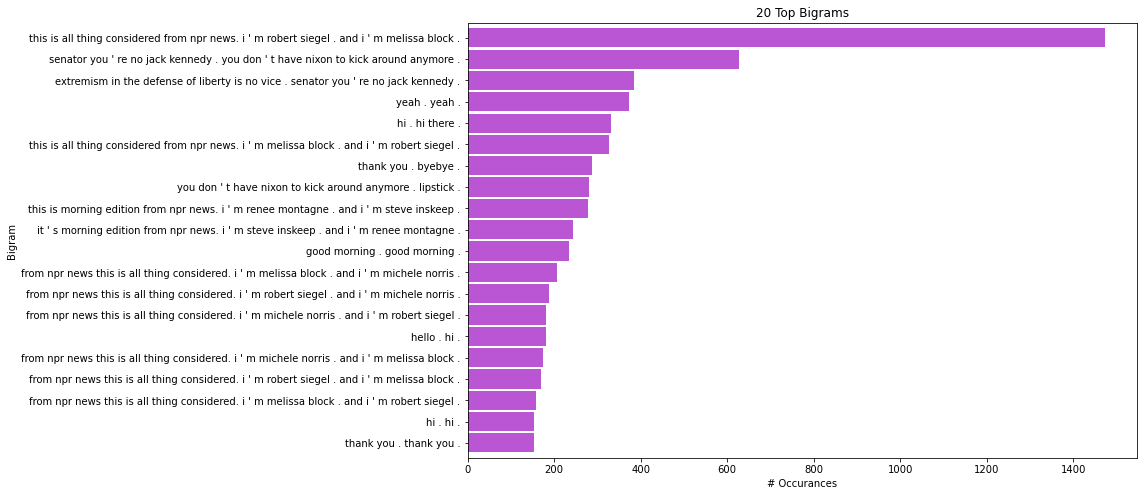

In [48]:
# Calculate bigrams
bigrams = (pd.Series(nltk.ngrams(df.lemmatized, 2))
                      .value_counts()
                      .head(20))
# Vizualize Bigrams
bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Top Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

## Initial Planning Analysis

In [19]:
# read in primary utterances csv for dataframe
df = pd.read_csv('./utterances.csv')
df.head()

,episode,episode_order,speaker,utterance
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ..."
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,..."
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra..."


In [20]:
# find utterance count per episode
df.episode.value_counts()

19633    569
35108    552
57481    539
73336    492
66523    480
        ... 
80400      1
61102      1
88047      1
73497      1
92554      1
Name: episode, Length: 104920, dtype: int64

In [21]:
# find utterance count per episode
test = df.episode.value_counts() < 2
test.sum()

1357

In [22]:
# pull in episodes df
ep_df = pd.read_csv('./episodes.csv')
ep_df.head()

,id,program,title,episode_date
0,98814,Morning Edition,Senate Ushers In New Year With 'Fiscal Cliff' ...,2013-01-01
1,98824,Morning Edition,Cheap Bubbly Or Expensive Sparkling Wine? Look...,2012-12-31
2,98821,Morning Edition,U.S. Gas Prices Reach Record Level In 2012,2013-01-01
3,98806,Morning Edition,House Approves 'Fiscal Cliff' Measure,2013-01-02
4,98823,Morning Edition,The Fiscal Cliff: A Love Story,2012-12-31


In [23]:
# check episode content to see if it matches episode id
df[df.episode == 92554].utterance.to_list()

["Good morning. I'm David Greene. Here's the weather forecast for Albuquerque, New Mexico today - cloudy with a chance of grasshoppers. Yes, that's right. The animals are swarming the city so densely, local radar is mistaking them for rain crowds. These insects are hovering in masses as high as a thousand feet up. Officials say this is the worst infestation in 20 years, but it should pass soon. With any luck, it will go back to raining rain - helping to clean up the mess left behind by these grasshoppers. You're listening to MORNING EDITION."]

In [24]:
# check ep_df.id = df.episode
ep_df[ep_df.id == 92554].title.to_list()

["Albuquerque's Weather? Cloudy With A Chance of Grasshoppers"]

### Initial takeaways
There are episodes with one utterance, showing less interview setting and more reporting.

ep_df.id == df.episode

## Sentiment Analysis

In [18]:
import nltk.sentiment
sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [20]:
df['vader'] = df.lemmatized.apply(lambda doc: sia.polarity_scores(doc)['compound'])

In [21]:
df['vader_stopped'] = df.lemmatized_stopped.apply(lambda doc: sia.polarity_scores(doc)['compound'])

In [26]:
df.drop(columns = ['vader','lemmatized'], inplace= True)

In [34]:
df['date'] = pd.to_datetime(df.episode_date)

In [36]:
df.drop(columns = 'episode_date', inplace = True)

In [37]:
df.head()

,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized_stopped,vader_stopped,date
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ...",Talk of the Nation,How To Watch The Tour De France,False,it s a 2200 mile race. to give some sense of p...,2200 mile race. give sense perspective roughly...,0.0000,2010-07-12
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...,Talk of the Nation,How To Watch The Tour De France,False,so for a top competitor like lance to try to m...,top competitor like lance try make much time 1...,0.9313,2010-07-12
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...",Talk of the Nation,How To Watch The Tour De France,True,so in every team presumably there s one star o...,every team presumably one star one equivalent ...,0.7096,2010-07-12
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...,Talk of the Nation,How To Watch The Tour De France,False,that s right. each team has nine riders. and w...,right. team ha nine riders. basically team lea...,0.9274,2010-07-12
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...",Talk of the Nation,How To Watch The Tour De France,True,so slipstream this is like drafting in car rac...,slipstream like drafting car racing right ?,0.3612,2010-07-12


In [40]:
df.to_csv('npr_corpus.csv', index = False)

In [4]:
df = wrangle.get_npr_data()

The df has 2998347 rows and 10 columns.


In [5]:
df.dropna(inplace=True)

In [112]:
df['speaker'] = df.speaker.str.lower()
df['is_host'] = df.speaker.str.contains(r'\W*(host)\W*')

In [6]:
df.sort_values(by=['episode_id','episode_order'])[0:50]

,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized_stopped,vader_stopped,date
episode_id,,,,,,,,,,
1,1,"lulu garcia-navarro, host",The impeachment inquiry picks up tomorrow wher...,Weekend Edition Sunday,Sunday Politics,True,the impeachment inquiry picks up tomorrow wher...,impeachment inquiry pick tomorrow left friday ...,-0.5267,2019-10-06
1,2,"lulu garcia-navarro, host",Good morning.,Weekend Edition Sunday,Sunday Politics,True,good morning .,good morning .,0.4404,2019-10-06
1,3,"mara liasson, byline","Good morning, Lulu.",Weekend Edition Sunday,Sunday Politics,False,good morning lulu .,good morning lulu .,0.4404,2019-10-06
1,4,"lulu garcia-navarro, host",All right. What's the latest?,Weekend Edition Sunday,Sunday Politics,True,all right. what s the latest ?,right. latest ?,0.0000,2019-10-06
1,5,"mara liasson, byline","Well, the latest is that the lawyer for the fi...",Weekend Edition Sunday,Sunday Politics,False,well the latest is that the lawyer for the fir...,well latest lawyer first whistleblower tweetin...,0.8402,2019-10-06
1,6,"lulu garcia-navarro, host","I mean, another whistleblower has got to be ba...",Weekend Edition Sunday,Sunday Politics,True,i mean another whistleblower has got to be bad...,mean another whistleblower ha got bad news pre...,0.1027,2019-10-06
1,7,"mara liasson, byline",No. This is kind of like a trail of bread crum...,Weekend Edition Sunday,Sunday Politics,False,no. this is kind of like a trail of bread crum...,no. kind like trail bread crumbs. revelation l...,0.9153,2019-10-06
1,8,"lulu garcia-navarro, host",What his happening to his support among Republ...,Weekend Edition Sunday,Sunday Politics,True,what his happening to his support among republ...,happening support among republican lawmaker ma...,0.6662,2019-10-06
1,9,"mara liasson, byline","So far, most Republican lawmakers are shelteri...",Weekend Edition Sunday,Sunday Politics,False,so far most republican lawmakers are shelterin...,far republican lawmaker sheltering place usual...,-0.6705,2019-10-06
